<h1 align="center">Introduction to Machine Learning - Course Code: 25737</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Question 3

</h4>

# Personal Data

In [1]:
# Set your student number
student_number = 99102072
Name = 'Omid'
Last_Name = 'Keshavarz'

# Autoencoders (25 Points)

In this problem, you should implement an autoencoder network, which generates an image presenting the next digit of the input digit. Here are some examples:

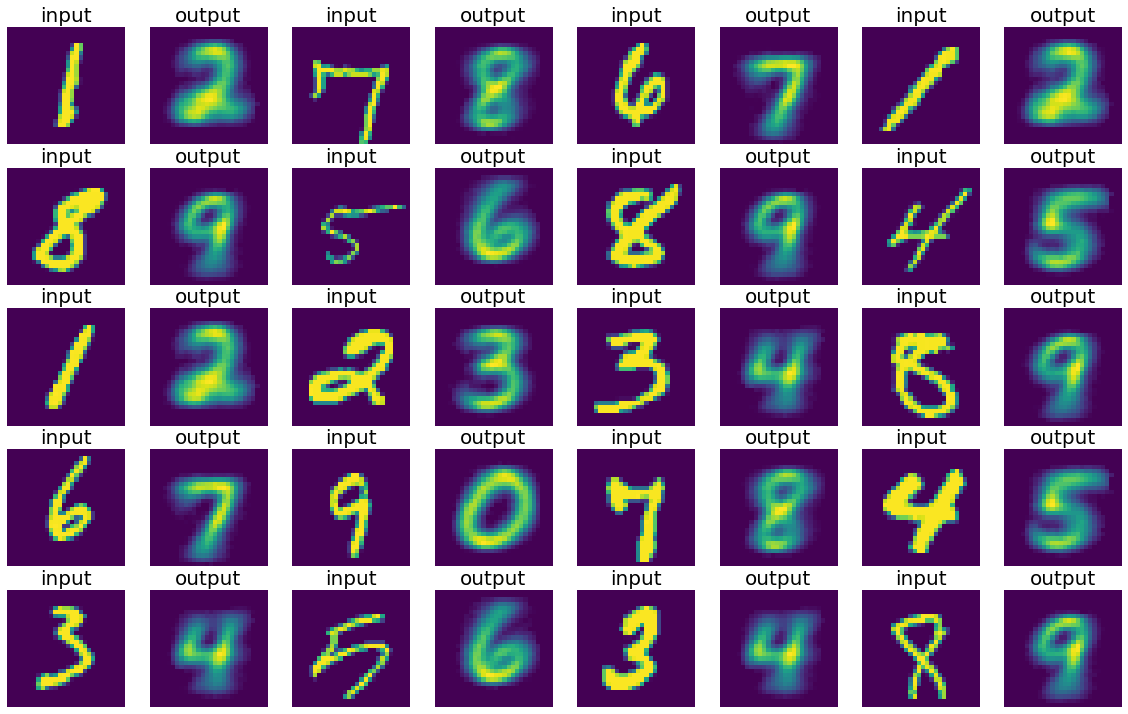

You should use the MNIST dataset, and the ground-truth for each example is provided by a helper function. Make sure to put the `ae_helper.py` file next to this notebook to use the helper function.

## Get the data

Get the data and split them into training, validation, and test sets, by running the following cell. `X` is the input images, `Y` is the ground-truth for each input, and `y` is the input's label.

In [3]:
from ae_helper import get_data
from sklearn.model_selection import train_test_split

X, Y, y = get_data()

X_train, X_test, Y_train, Y_test, y_train, y_test = train_test_split(X, Y, y, test_size=0.2, random_state=17)
X_train, X_val, Y_train, Y_val, y_train, y_val = train_test_split(X_train, Y_train, y_train, test_size=0.1, random_state=17)


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


## Design your model

Please Implement your autoencoder model below. You MUST implement your model using the `torch` package. The model should input a batch of images and output the generated images for the whole batch. Your model can be consist of fully connected layers (using linear layers), but using fully-convolutional models has extra points.

In [80]:
#### IMPLEMENT YOUR MODEL ####
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn import functional as F

class Encoder(nn.Module):

    def __init__(self, latent_size):
        super().__init__()

        # CONVOLUTIONAL
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=0),
            nn.ReLU(True)
        )

        # FLATTEN
        self.flatten = nn.Flatten(start_dim=1)

        # LINEAR
        self.linear = nn.Sequential(
            nn.Linear(3 * 3 * 64, 128),
            nn.ReLU(True),
            nn.Linear(128, latent_size)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.flatten(x)
        x = self.linear(x)
        return x


class Decoder(nn.Module):

    def __init__(self, latent_size):
        super().__init__()

        self.linear = nn.Sequential(
            nn.Linear(latent_size, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 64),
            nn.ReLU(True)
        )

        # UNFLATTEN
        self.unflatten = nn.Unflatten(dim=1,
        unflattened_size=(64, 3, 3))

        # CONVOLUTIONAL_TRANSPOSE
        self.convtranspose = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3,
            stride=2, output_padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2,
            padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=2,
            padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.linear(x)
        x = self.unflatten(x)
        x = self.convtranspose(x)
        x = torch.sigmoid(x)
        return x


class AutoEncoder(nn.Module):
    def __init__(self, latent_size):
        super().__init__()

        self.encoder = Encoder(latent_size)
        self.decoder = Decoder(latent_size)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## The dataset class, and the dataloaders

The following cells implement the dataset class and create the data loaders for training and validation sets. Feel free to modify the batch size for each data loader.

In [75]:
from typing import Tuple
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class MnistNextDigitDataset(Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray, y: np.ndarray):
        self.X = torch.from_numpy(X)
        self.Y = torch.from_numpy(Y)
        self.y = torch.from_numpy(y)

    def __len__(self) -> int:
        return self.X.shape[0]

    def __getitem__(self, i: int) -> Tuple[torch.Tensor, ...]:
        return self.X[i], self.Y[i], self.y[i]

In [76]:
train_dataloader = DataLoader(
    MnistNextDigitDataset(X_train, Y_train, y_train),
    batch_size=512,
    shuffle=True
)
val_dataloader = DataLoader(
    MnistNextDigitDataset(X_val, Y_val, y_val),
    batch_size=1024,
    shuffle=False
)

In [97]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'



def train_epoch(autoencoder, device, dataloader, loss_fn, optimizer):
    autoencoder.train()
    train_loss = []
    for b, image_batch in enumerate(dataloader):
        image_batch_X = image_batch[0].unsqueeze(1).to(device)
        image_batch_Y = image_batch[1].unsqueeze(1).to(device)
        decoded_data = autoencoder(image_batch_X)
        loss = loss_fn(decoded_data, image_batch_Y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (b+1)%10==0:
            print(f"\t train loss on {b+1}-th batch: %f" % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss)


def test_epoch(autoencoder, device, dataloader, loss_fn):
    autoencoder.eval()
    with torch.no_grad():
        conc_out = []
        conc_label = []
        for b, image_batch in enumerate(dataloader):
            image_batch_X = image_batch[0].unsqueeze(1).to(device)
            image_batch_Y = image_batch[1].unsqueeze(1).to(device)
            decoded_data = autoencoder(image_batch_X)
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch_Y.cpu())
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label)
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

def train_autoencoder(model: nn.Module, optimizer: optim.Optimizer, dataloader: DataLoader) -> float:
    model.train()  # Set the model to training mode
    epoch_loss = 0.0

    for batch in dataloader:
        inputs, targets,_ = batch
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = nn.MSELoss()(outputs, targets)  # Compute the Mean Squared Error loss
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * inputs.size(0)

    epoch_loss /= len(dataloader.dataset)

    return epoch_loss

def eval_autoencoder(model: nn.Module, dataloader: DataLoader) -> float:
    model.eval()  # Set the model to evaluation mode
    epoch_loss = 0.0

    with torch.no_grad():
        for batch in dataloader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)

            loss = nn.MSELoss()(outputs, targets)  # Compute the Mean Squared Error loss

            epoch_loss += loss.item() * inputs.size(0)

    epoch_loss /= len(dataloader.dataset)

    return epoch_loss


In [101]:
def plot_outputs(autoencoder, n=40):
    plt.figure(figsize=(6, 2))
    t_idx = np.random.randint(0, X_test.shape[0], n)

    for i in range(n):
      ax = plt.subplot(int(n/10), 10, i+1)
      img = X_test[t_idx[i]]
      autoencoder.eval()
      with torch.no_grad():
         img = torch.tensor(img.reshape((1, 1, 28, 28))).to(device)
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
    plt.suptitle("Random inputs", fontweight="bold")
    plt.show()

    plt.figure(figsize=(6, 2))
    for i in range(n):
      ax = plt.subplot(int(n/10), 10, i+1)
      img = X_test[t_idx[i]]
      autoencoder.eval()
      with torch.no_grad():
         img = torch.tensor(img.reshape((1, 1, 28, 28))).to(device)
         rec_img = autoencoder(img)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
    plt.suptitle("Outputs", fontweight="bold")
    plt.show()

## Instantiate the model and optimizer

Instantiate your model and optimizer in the following cell. Feel free to choose the optimizer and its configurations such as learning rate, decay, etc.

In [99]:
latent_size = 8
lr = 0.001
weight_decay=1e-05

autoencoder = AutoEncoder(latent_size)
params = [{"params": autoencoder.parameters()}]
optim = torch.optim.Adam(params, lr=lr, weight_decay=weight_decay)
loss_fn = torch.nn.MSELoss()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device: {device}")
autoencoder.to(device)

Device: cuda


AutoEncoder(
  (encoder): Encoder(
    (cnn): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU(inplace=True)
      (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
      (6): ReLU(inplace=True)
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear): Sequential(
      (0): Linear(in_features=576, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=8, bias=True)
    )
  )
  (decoder): Decoder(
    (linear): Sequential(
      (0): Linear(in_features=8, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=576, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(dim=1, unflattened_size=(64, 3, 3)

## Train your autoencoder

Write your training/validation loop in the following cell for an arbitrary number of epochs (until convergence is detected). Make sure to use proper and readable logging containing training and validation metrics for each epoch. Select and store the state dictionary of the best epoch model according to the metrics.

In [112]:
#### IMPLEMENT YOUR TRAIN/VAL LOOP ####

num_epochs = 15

best_val_loss = float('inf')
best_model_state = None

loss_data = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   print("---")
   train_loss = train_epoch(autoencoder, device, train_dataloader, loss_fn, optim)
   val_loss = test_epoch(autoencoder, device, val_dataloader, loss_fn)
   print('\n Epoch {}/{} \t train loss {} \t val loss {}\n'.format(epoch + 1, num_epochs, train_loss, val_loss))
   loss_data['train_loss'].append(train_loss)
   loss_data['val_loss'].append(val_loss)
   if val_loss < best_val_loss:
      best_val_loss = val_loss
      best_model_state = autoencoder.state_dict().copy()  # Save a copy of the model state

# Optionally, save the best model state to a file
if best_model_state is not None:
    torch.save(best_model_state, 'best_autoencoder_model.pth')

---
	 train loss on 10-th batch: 0.050309
	 train loss on 20-th batch: 0.050694
	 train loss on 30-th batch: 0.050905
	 train loss on 40-th batch: 0.052432
	 train loss on 50-th batch: 0.050840
	 train loss on 60-th batch: 0.052319
	 train loss on 70-th batch: 0.051549
	 train loss on 80-th batch: 0.052177
	 train loss on 90-th batch: 0.053067

 Epoch 1/15 	 train loss 0.05144467577338219 	 val loss 0.056874535977840424

---
	 train loss on 10-th batch: 0.050763
	 train loss on 20-th batch: 0.050484
	 train loss on 30-th batch: 0.049396
	 train loss on 40-th batch: 0.050800
	 train loss on 50-th batch: 0.051207
	 train loss on 60-th batch: 0.052097
	 train loss on 70-th batch: 0.051870
	 train loss on 80-th batch: 0.052622
	 train loss on 90-th batch: 0.052137

 Epoch 2/15 	 train loss 0.05122758820652962 	 val loss 0.05704151466488838

---
	 train loss on 10-th batch: 0.051035
	 train loss on 20-th batch: 0.049995
	 train loss on 30-th batch: 0.050962
	 train loss on 40-th batch: 0.05

## Load the state dictionary of the best epoch

Load the state dictionary of the best epoch model into the model object.

In [104]:
#### LOAD THE BEST EPOCH STATE DICTIONARY ####
ae.load_state_dict(torch.load('best_autoencoder_model.pth'))

print("Best model loaded.")

Best model loaded.


## Visualize your model

Select 40 examples from the test set and visualize the input and output of the model for them (See the examples at the beginning of the notebook).

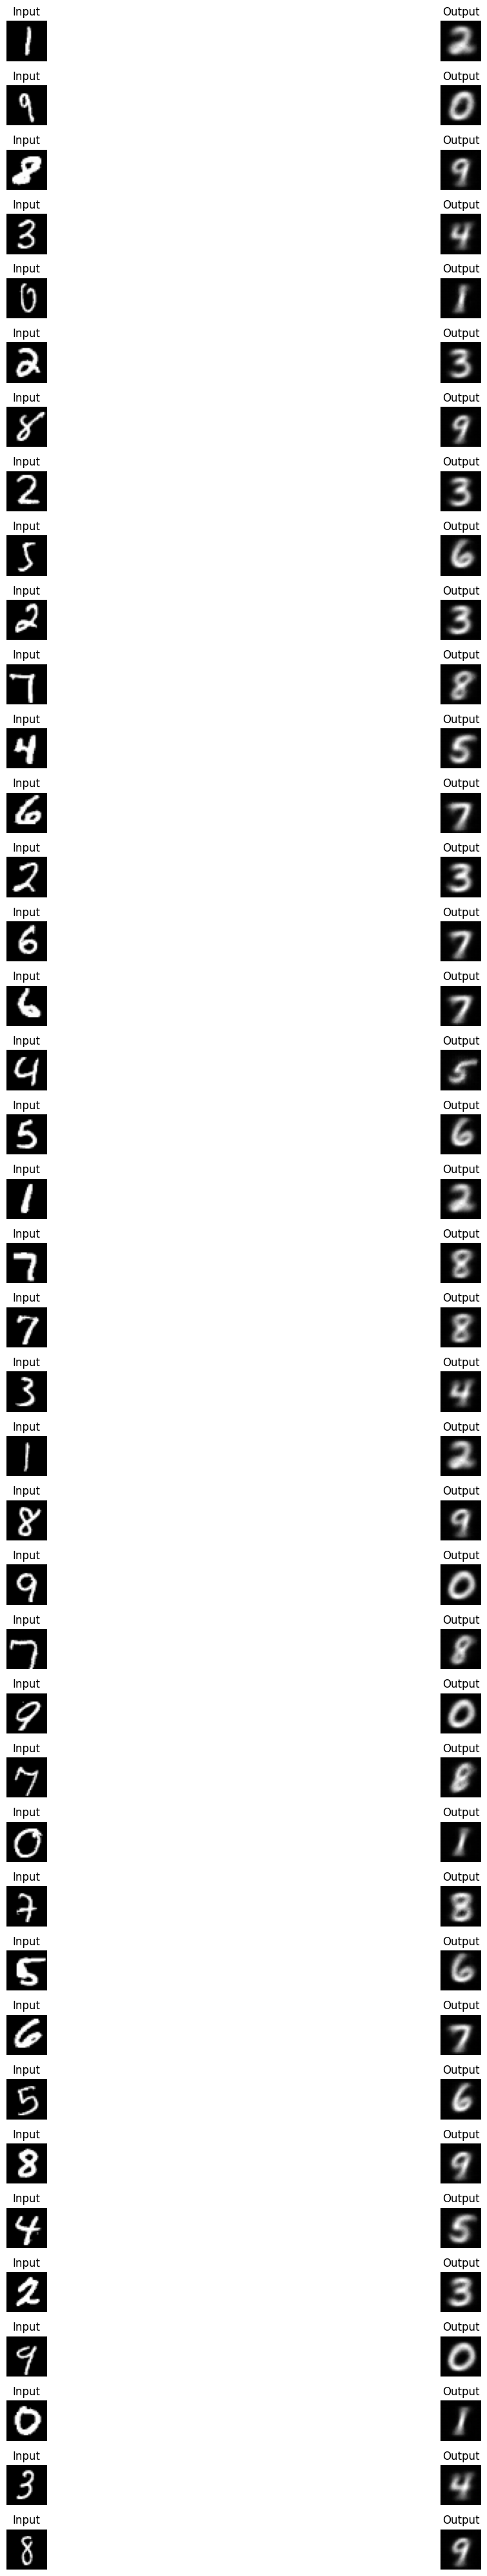

In [111]:
#### VISUALIZE YOUR MODEL ####
import matplotlib.pyplot as plt

# Assuming you have a test dataset
test_dataloader = DataLoader(
    MnistNextDigitDataset(X_test, Y_test, y_test),
    batch_size=40,  # Load 40 examples at once
    shuffle=False
)

# Get a batch of test data
inputs, inputs_y, targets = next(iter(test_dataloader))
inputs, targets = inputs.to(device), targets.to(device)

inputs = inputs.unsqueeze(1)

# Get the model's output for the test data
outputs = ae(inputs)

# Move the data back to CPU for visualization
inputs = inputs.cpu().detach().numpy()
outputs = outputs.cpu().detach().numpy()

# Function to plot input and output images
def plot_images(inputs, outputs, num_images=40):
    plt.figure(figsize=(20, 40))
    for i in range(num_images):
        # Input image
        plt.subplot(num_images, 2, 2*i + 1)
        plt.imshow(inputs[i, 0], cmap='gray')
        plt.title('Input')
        plt.axis('off')

        # Output image
        plt.subplot(num_images, 2, 2*i + 2)
        plt.imshow(outputs[i, 0], cmap='gray')
        plt.title('Output')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot the input and output images
plot_images(inputs, outputs, num_images=40)
